# Automatic generation of google ngram graphs in Python

The [Google Ngram Viewer](https://en.wikipedia.org/wiki/Google_Ngram_Viewer) allows you to plot the usage trajectories of words over time.

It has a [convient web-interface](https://books.google.com/ngrams), but for frequent usage you might want to generate word usage plots in python. 
<!-- TEASER_END -->

In [1]:
%matplotlib inline

import re
from ast import literal_eval

import requests
import pandas as pd
import matplotlib.pyplot as plt

Define what data you want to extract:

In [2]:
search_para = dict(
    # coma separeted list of search terms:
    content='climate change, global warming',
    # start year, 1500 is the minimal year for corpus 'eng_2012'
    year_start=1950, 
    # end year, 2008 is the max for corpus 'eng_2012'
    year_end=2008,  
    # The value of 'case_insensitve' does not matter, remove the parameter for case_sensitive 
    case_insensitive='whatever', 
    # smooth over x years
    smoothing=3,           
    corpus='eng_2012'
)

We do some error checking here, since google silently provides truncated data if requested to much:

In [3]:
if search_para['year_start'] < 1500:
    raise ValueError("Start year must be after 1499")
if 2008 < search_para['year_end']:
    raise ValueError("End year must be befor 2009")

The actual data extraction is done with request:


In [4]:
req = requests.get('http://books.google.com/ngrams/graph', params=search_para)
res_raw = re.findall('var data = (.*?);\\n', req.text)
res_clean = literal_eval(res_raw[0])  # Its a valid data structure at this point
res_parsed = {content['ngram']: content['timeseries']
              for content in res_clean}

After the parsing, we can convert the data into a dataframe and at an index:

In [5]:
freq = pd.DataFrame(res_parsed)
freq.index = list(range(search_para['year_start'], 
                        search_para['year_end'] + 1))

Google alreay provides the sum of the different cases of the search term.
These can be identified with '(All)'. However, these columns are absent if case sensitive data is requested. The following matches both cases:

In [6]:
totals = freq[[col for col in freq.columns if '(All)' in col]]
if len(totals) == 0:
    totals = freq

Lets show the final dataset:

In [7]:
totals.head()

,climate change (All),global warming (All)
1950,5.629219e-09,0.000000e+00
1951,5.077090e-09,1.147430e-10
1952,6.680804e-09,1.863561e-10
1953,8.050352e-09,1.059327e-09
1954,1.363747e-08,1.757183e-09


And finally plot the term frequency over time:

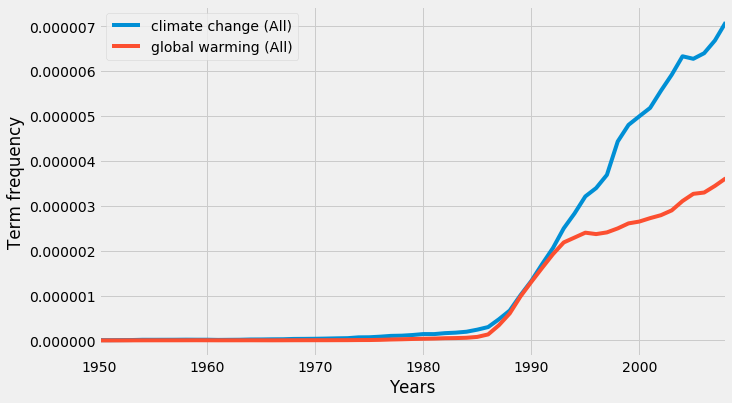

In [8]:
plt.style.use('fivethirtyeight')
totals.plot(figsize=(10, 6))
plt.xlabel('Years')
plt.ylabel('Term frequency')